# Jupyter notebook to set up joint inversion of magnetic and gravity data (SWARM project)
This jupyter notebook prepares the input data and sets up the joint inversion for the academic inversion code JIF3D developed by Max Moorkamp et al. https://sourceforge.net/projects/jif3d/.

This jupyter notebook reads in magnetic and gravity measurements with the associated station heights as well as the bedrock topography. The data is transferred into SI units except for the magnetic data. Additionally, this notebook prepares the inversion model (mesh) for the joint inversion model with a 20 % padding around the measured input data. The prepared input data and inversion mesh’s are stored in NetCDF's files, which are used by JIF3D. Finally, this notebook creates a Linux shell script, which calls the inversion code and passes the required information of the NetCDF files.

#### jupyter notebook written by Maximilian Lowe (maxwe32@bas.ac.uk). Last update 04/10/2024

#### import python packages

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from cmcrameri import cm
import cartopy.crs as ccrs
import os
from scipy.interpolate import griddata
import geopandas as gpd

#### define gobal parameters

In [2]:
cmap_rev = cm.roma_r
cmap = cm.roma

# paths
Inversion_run = "SWARM_mag_only"
# Create path if it does not exists
if not os.path.exists(Inversion_run):
    os.makedirs(Inversion_run)

inversion_path = Inversion_run + "/VI_inversion/"
# Create path if it does not exists
if not os.path.exists(inversion_path):
    os.makedirs(inversion_path)

#### load data

In [3]:
Mag_data_pd = pd.read_csv(
    "DATA/Mag_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "Mag", "Alti"],
)

Grav_data_pd = pd.read_csv(
    "DATA/Grav_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "Grav", "Alti"],
)

Boundaries_SWARM = pd.read_csv(
    "DATA/Topo_reprojected.txt",
    skiprows=1,
    names=["x_ps", "y_ps", "bedrock"],
)

In [4]:
## Magnetic Data
mag_x = Mag_data_pd.x_ps
mag_y = Mag_data_pd.y_ps
mag_val = Mag_data_pd.Mag
mag_z = Mag_data_pd.Alti * -1  # model geometry is defined as postive = down

# set data error to 1 nT
mag_T_sigma = np.ones(mag_val.shape)

In [5]:
# grav data
Grav_data = Grav_data_pd.to_numpy()  # transfer panda dataframe to numpy arrays

# define coordinates and data values
grav_x = Grav_data[:, 0]
grav_y = Grav_data[:, 1]
grav_BA = Grav_data[:, 2]
grav_MeasZ = Grav_data[:, 3] * -1  # model geometry is defined as postive = down


## convert gravity data from mGal to SI unit
grav_BA_si = grav_BA * 1e-5

# set a global gravity error to 0 mGal
grav_BA_si_sigma = np.ones(grav_BA_si.shape) * 0  # * 1e-5

In [6]:
## Boundary condition (Topography, Curie Point Depths and Moho depth)
boundary_x = Boundaries_SWARM.x_ps
boundary_y = Boundaries_SWARM.y_ps
boundary_Topo = (
    Boundaries_SWARM.bedrock * -1
)  # model geometry is defined as postive = down

boundary_Moho = np.zeros(len(boundary_x)) + 22000

print(
    "highest topo:",
    min(boundary_Topo),
    "m",
    "\n" "lowest topo:",
    max(boundary_Topo),
    "m",
    "\n",
)

highest topo: -2143.67456054688 m 
lowest topo: 1503.42333984375 m 



### Plotting input data


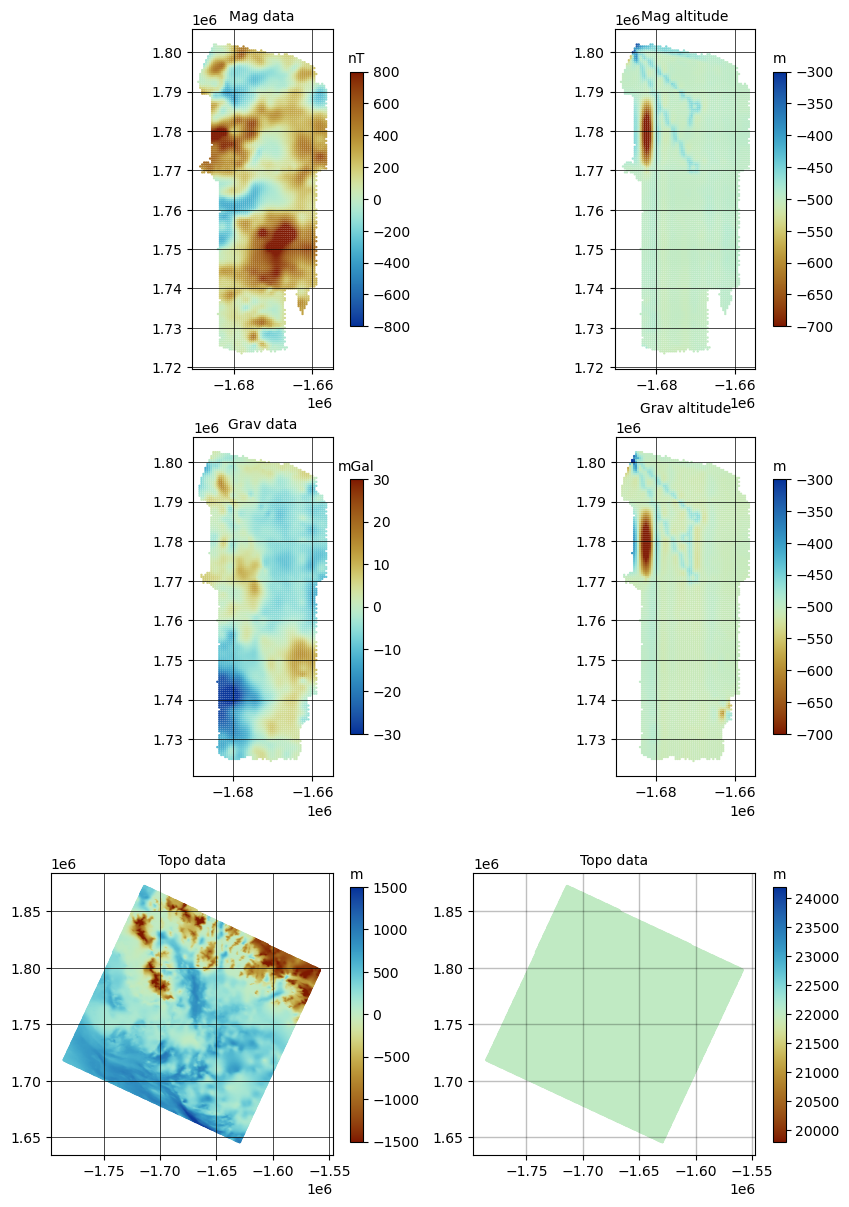

In [7]:
# create figure
figure1 = plt.figure(figsize=(10, 15), facecolor="white")

# mag data
ax1 = plt.subplot(3, 2, 1)
plt.title("Mag data", fontsize=10)
im1 = plt.scatter(mag_x, mag_y, 0.5, c=mag_val, cmap=cmap_rev, vmin=-800, vmax=800)
ax1.grid(linewidth=0.5, color="k", alpha=1, linestyle="-")
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=0.75)
cb.ax.set_title("nT", fontsize=10)

# mag alti
ax2 = plt.subplot(3, 2, 2)
plt.title("Mag altitude", fontsize=10)
im2 = plt.scatter(mag_x, mag_y, 0.5, c=mag_z, cmap=cmap, vmin=-700, vmax=-300)
ax2.grid(linewidth=0.5, color="k", alpha=1, linestyle="-")
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im2, shrink=0.75)
cb.ax.set_title("m", fontsize=10)

# grav data
ax3 = plt.subplot(3, 2, 3)
plt.title("Grav data", fontsize=10)
im1 = plt.scatter(
    grav_x, grav_y, 0.5, c=grav_BA_si / 1e-5, cmap=cmap_rev, vmin=-30, vmax=30
)
ax3.grid(linewidth=0.5, color="k", alpha=1, linestyle="-")
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=0.75)
cb.ax.set_title("mGal", fontsize=10)

# grav alti
ax4 = plt.subplot(3, 2, 4)
plt.title("Grav altitude", fontsize=10)
im4 = plt.scatter(grav_x, grav_y, 0.5, c=grav_MeasZ, cmap=cmap, vmin=-700, vmax=-300)
ax4.grid(linewidth=0.5, color="k", alpha=1, linestyle="-")
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im4, shrink=0.75)
cb.ax.set_title("m", fontsize=10)

# Topo data
ax5 = plt.subplot(3, 2, 5)
plt.title("Topo data", fontsize=10)
im5 = plt.scatter(
    boundary_x, boundary_y, 0.5, c=boundary_Topo, cmap=cmap, vmin=-1500, vmax=1500
)
ax5.grid(linewidth=0.5, color="k", alpha=1, linestyle="-")
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im5, shrink=0.75)
cb.ax.set_title("m", fontsize=10)

# Moho data
ax6 = plt.subplot(3, 2, 6)
plt.title("Topo data", fontsize=10)
im6 = plt.scatter(boundary_x, boundary_y, 0.5, c=boundary_Moho, cmap=cmap)
ax6.grid(linewidth=0.5, color="k", alpha=1, linestyle="-")
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im6, shrink=0.75)
cb.ax.set_title("m", fontsize=10)
plt.grid(color="k", linestyle="-", linewidth=1, alpha=0.25)

## Create Mag and Grav netCDF

In [8]:
## Magnetics
# define name of the NetCDF file
mag_data_file = Dataset(inversion_path + "magdata.nc", "w")

# The number of stations within the bounds specified above
nstat = mag_x.size

# create a dimension with the corret number of stations
statdim = mag_data_file.createDimension("StationNumber", nstat)

## x coordinates
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasx = mag_data_file.createVariable("MeasPosX", "f8", ("StationNumber"))
# set the units metadata entry for the variable MeasPosX
vmeasx.units = "m"
# fill the variable
vmeasx[:] = mag_x

## y coordinates
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasy = mag_data_file.createVariable("MeasPosY", "f8", ("StationNumber"))
# set the units metadata entry for the variable MeasPosY
vmeasy.units = "m"
# fill the variable
vmeasy[:] = mag_y

## z coordinates (station height)
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasz = mag_data_file.createVariable("MeasPosZ", "f8", ("StationNumber"))
# set the units metadata entry for the variable MeasPosZ
vmeasz.units = "m"
# fill the variable
vmeasz[:] = mag_z

## BA gravity values
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vT = mag_data_file.createVariable("T", "f8", ("StationNumber"))
# set the units metadata entry for the variable Scalar_gravity
vT.units = "nT"
# fill the variable
vT[:] = mag_val

## BA gravity uncertainty value
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vdT = mag_data_file.createVariable("dT", "f8", ("StationNumber"))
# set the units metadata entry for the variable dGz
vdT.units = "nT"
# fill the variable
vdT[:] = mag_T_sigma

# close the file
mag_data_file.close()

In [9]:
## Gravity
# define name of the NetCDF file
grav_data_file = Dataset(inversion_path + "gravdata.nc", "w")

# The number of stations within the bounds specified above
nstat = grav_x.size

# create a dimension with the corret number of stations
statdim = grav_data_file.createDimension("StationNumber", nstat)

## x coordinates
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasx = grav_data_file.createVariable("MeasPosX", "f8", ("StationNumber"))
# set the units metadata entry for the variable MeasPosX
vmeasx.units = "m"
# fill the variable
vmeasx[:] = grav_x

## y coordinates
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasy = grav_data_file.createVariable("MeasPosY", "f8", ("StationNumber"))
# set the units metadata entry for the variable MeasPosY
vmeasy.units = "m"
# fill the variable
vmeasy[:] = grav_y

## z coordinates (station height)
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vmeasz = grav_data_file.createVariable("MeasPosZ", "f8", ("StationNumber"))
# set the units metadata entry for the variable MeasPosZ
vmeasz.units = "m"
# fill the variable
vmeasz[:] = grav_MeasZ

## BA gravity values
# create an empty one-dimensional array variable with a number of placeholder specified by the dimension StationNumber
vgz = grav_data_file.createVariable("Scalar_gravity", "f8", ("StationNumber"))
# set the units metadata entry for the variable Scalar_gravity
vgz.units = "m/s2"
# fill the variable
vgz[:] = grav_BA_si

## BA gravity uncertainty value
# create an empty one-dimensional array variable with a number of placeholderspecified by the dimension StationNumber
vdgz = grav_data_file.createVariable("dGz", "f8", ("StationNumber"))
# set the units metadata entry for the variable dGz
vdgz.units = "m/s2"
# fill the variable
vdgz[:] = grav_BA_si_sigma

# close the file
grav_data_file.close()

### create magnetic and gravity inversion mesh

In [10]:
### check inversion mesh extrensions
model_res = 250
data_extension_x = np.max(mag_x) - np.min(mag_x)
data_extension_y = np.max(mag_y) - np.min(mag_y)

# check number of core inversion cells
nx_ix = int(data_extension_x / model_res)
ny_ix = int(data_extension_y / model_res)

# calculate 20 procent padding around the meassured data points
padding_x = (data_extension_x * 20) / 100
padding_y = (data_extension_y * 20) / 100

# add padding range onto the model extention
model_extention_x = data_extension_x + (2 * padding_x)
model_extention_y = data_extension_y + (2 * padding_y)

print("nx:", nx_ix, "\n", "ny:", ny_ix, "\n")

nx: 130 
 ny: 314 



In [11]:
# set the total number of core cells in each direction
nx = nx_ix
ny = ny_ix
nz = 33

# how many horizontal padding cells do we want
padx = 14
pady = 14

# set the cell sizes in the core area in m, cells on the outside will grow
deltax = model_res
deltay = model_res
deltaz = 100

# the factor by which we increase layer thickness and size of padding cells
increasehor = 1.2
increasever = 1.1

# calculate the center position for the measurements
centerx = (np.min(mag_x) + np.max(mag_x)) / 2.0
centery = (np.min(mag_y) + np.max(mag_y)) / 2.0

xpadspacing = np.round(deltax * np.power(increasehor, np.arange(0, padx)))
ypadspacing = np.round(deltay * np.power(increasehor, np.arange(0, pady)))
xpadwidth = np.sum(xpadspacing)
ypadwidth = np.sum(ypadspacing)

# calculate the model origin so the center of measurements is in the center of the model
startx = centerx - nx / 2 * deltax - xpadwidth
starty = centery - ny / 2 * deltay - ypadwidth
xpadbottom = startx + np.cumsum(xpadspacing[::-1])
ypadleft = starty + np.cumsum(ypadspacing[::-1])
xcore = xpadbottom[-1] + np.cumsum(np.ones(nx) * deltax)
ycore = ypadleft[-1] + np.cumsum(np.ones(ny) * deltay)
xpadtop = xcore[-1] + np.cumsum(xpadspacing)
ypadright = ycore[-1] + np.cumsum(ypadspacing)
X_PS = np.concatenate((xpadbottom, xcore, xpadtop))
Y_PS = np.concatenate((ypadleft, ycore, ypadright))
# when we consider topography we have to set the origin of the mesh in z-direction to the highest topography
# also remember positive down, so above ground is negative
startz = -2200
# calculate the layer thicknesses with depth
# we round to full meters because
# a) it is a bit ridiculous to work with sub meter precision when inverting lithospheric structures
# b) we run into all kinds of floating point precision issues when trying to compare numbers
thick = np.round(deltaz * np.power(increasever, np.arange(0, nz)))
# calculate layer depth from thickness
Depth = startz + np.cumsum(thick)
# calculate cell bounbdaries in north direction from specified number of cells and cell size
Susceptibility = np.zeros([nz, ny + 2 * pady, nx + 2 * padx])
bg_Susceptibility = np.zeros(nz)
bg_Susceptibility = thick

Depth = startz + np.cumsum(thick)
# calculate cell bounbdaries in north direction from specified number of cells and cell size
Density = np.zeros([nz, ny + 2 * pady, nx + 2 * padx])
bg_densities = np.zeros(nz)
bg_dens_thickness = thick

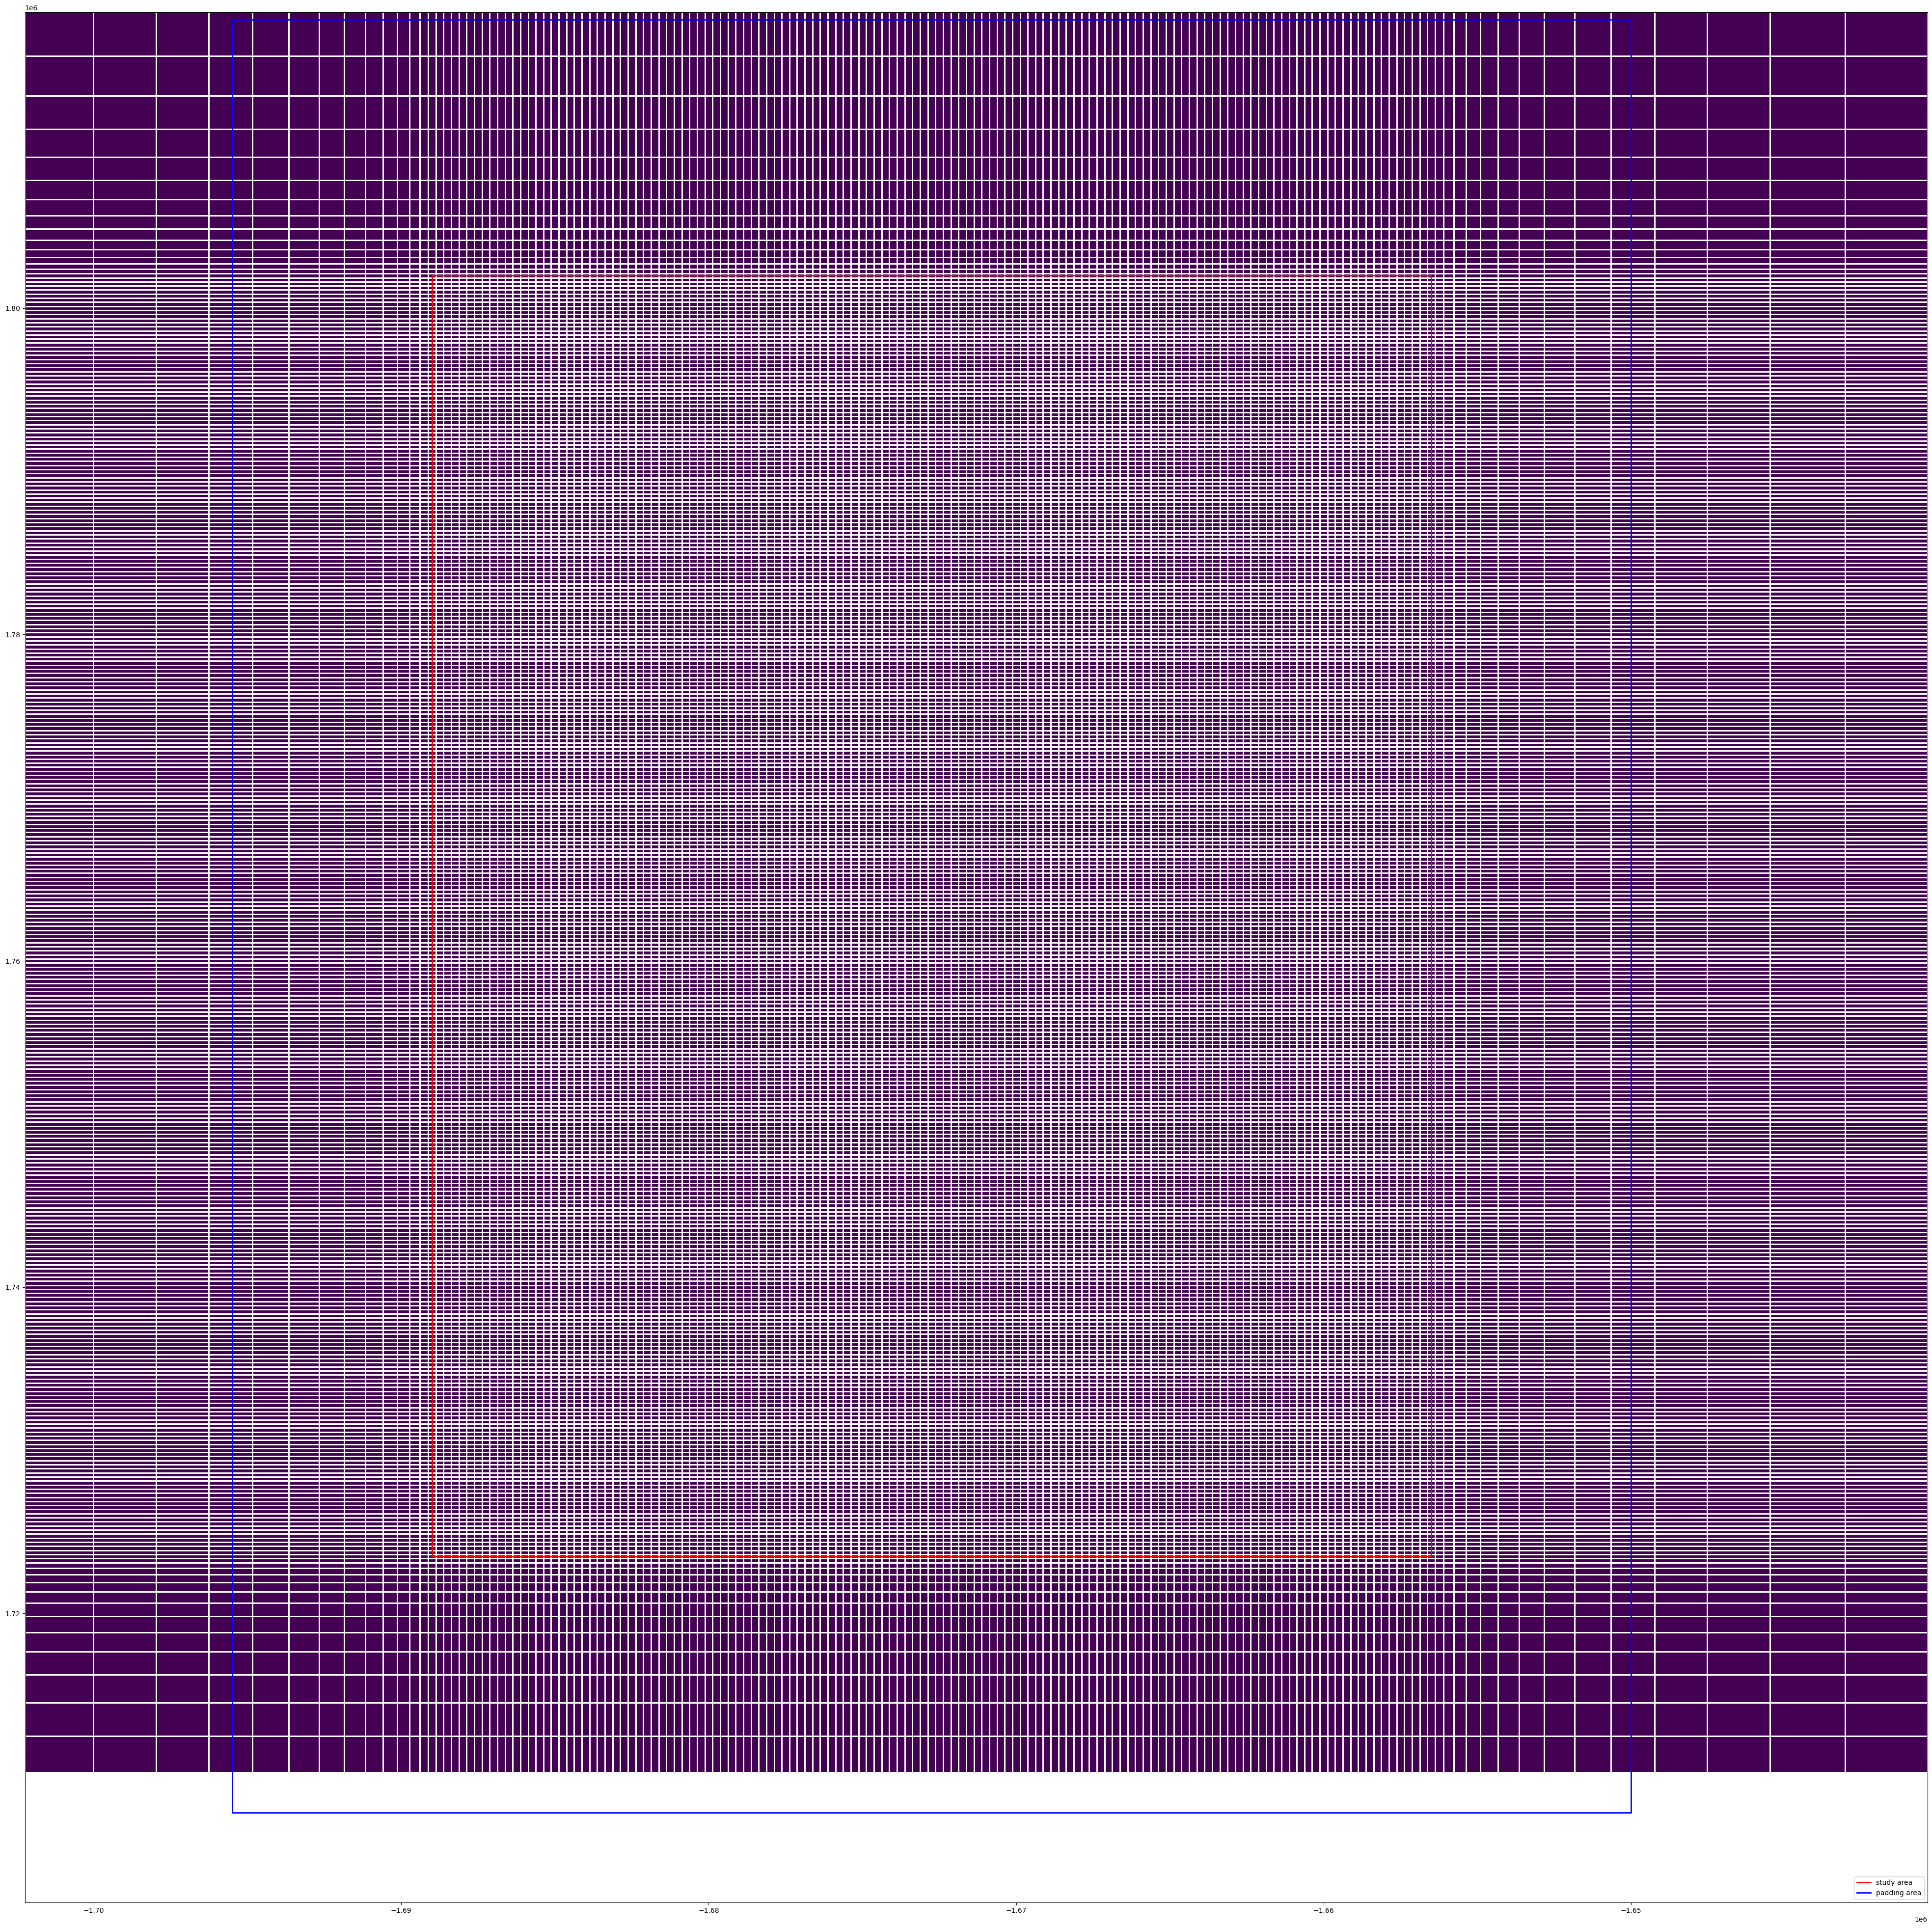

X-pad: [ 250.  300.  360.  432.  518.  622.  746.  896. 1075. 1290. 1548. 1858.
 2229. 2675.]
Y-pad: [ 250.  300.  360.  432.  518.  622.  746.  896. 1075. 1290. 1548. 1858.
 2229. 2675.]
X-center: -1672750.0
Y-center: 1762750.0
X-Origin: -1703799.0
Y-Origin: 1708701.0
X_PS: [-1701124. -1698895. -1697037. -1695489. -1694199. -1693124. -1692228.
 -1691482. -1690860. -1690342. -1689910. -1689550. -1689250. -1689000.
 -1688750. -1688500. -1688250. -1688000. -1687750. -1687500. -1687250.
 -1687000. -1686750. -1686500. -1686250. -1686000. -1685750. -1685500.
 -1685250. -1685000. -1684750. -1684500. -1684250. -1684000. -1683750.
 -1683500. -1683250. -1683000. -1682750. -1682500. -1682250. -1682000.
 -1681750. -1681500. -1681250. -1681000. -1680750. -1680500. -1680250.
 -1680000. -1679750. -1679500. -1679250. -1679000. -1678750. -1678500.
 -1678250. -1678000. -1677750. -1677500. -1677250. -1677000. -1676750.
 -1676500. -1676250. -1676000. -1675750. -1675500. -1675250. -1675000.
 -1674750. -16

In [12]:
### plot mesh
xq, yq = np.meshgrid(X_PS, Y_PS, indexing="ij")

fig = plt.figure(figsize=(50, 50))
plt.pcolormesh(xq, yq, np.transpose(Susceptibility[0, :, :]), edgecolors="white")
# define study area and padding area for plotting
x_study_area = [
    np.min(mag_x),
    np.max(mag_x),
    np.max(mag_x),
    np.min(mag_x),
    np.min(mag_x),
]
y_study_area = [
    np.min(mag_y),
    np.min(mag_y),
    np.max(mag_y),
    np.max(mag_y),
    np.min(mag_y),
]
plt.plot(x_study_area, y_study_area, "r", linewidth=2, label="study area")
x_padding_area = [
    np.min(mag_x) - padding_x,
    np.max(mag_x) + padding_x,
    np.max(mag_x) + padding_x,
    np.min(mag_x) - padding_x,
    np.min(mag_x) - padding_x,
]
y_padding_area = [
    np.min(mag_y) - padding_y,
    np.min(mag_y) - padding_y,
    np.max(mag_y) + padding_y,
    np.max(mag_y) + padding_y,
    np.min(mag_y) - padding_y,
]
plt.plot(x_padding_area, y_padding_area, "blue", linewidth=2, label="padding area")
plt.legend(loc="lower right")
# fig.savefig('Mensa_range_horizontal_increasing_mesh.png', format='png',dpi=500)

plt.show()
print("X-pad:", xpadspacing)
print("Y-pad:", ypadspacing)
print("X-center:", centerx)
print("Y-center:", centery)
print("X-Origin:", startx)
print("Y-Origin:", starty)
print("X_PS:", X_PS)
print("Y_PS:", Y_PS)
print("Thicknesses:", thick)
print("Depth", Depth)

In [13]:
# create magnetic mesh
model_mag = Dataset(inversion_path + "start_mag.nc", "w")
Grid_x_dim = model_mag.createDimension("Northing", X_PS.size)
Grid_y_dim = model_mag.createDimension("Easting", Y_PS.size)
Depthdim = model_mag.createDimension("Depth", Depth.size)
bgdim = model_mag.createDimension("bg_layers", bg_Susceptibility.size)

v_x_direction = model_mag.createVariable("Northing", "f8", ("Northing"))
v_x_direction[:] = X_PS[:]
v_x_direction.units = "m"

v_x_direction_orig = model_mag.createVariable("Northing_Origin", "f8")
v_x_direction_orig[:] = startx

v_y_direction = model_mag.createVariable("Easting", "f8", ("Easting"))
v_y_direction[:] = Y_PS[:]
v_y_direction.units = "m"
v_y_direction_orig = model_mag.createVariable("Easting_Origin", "f8")
v_y_direction_orig[:] = starty

vdepth = model_mag.createVariable("Depth", "f8", ("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_mag.createVariable("Depth_Origin", "f8")
vdepth_orig[:] = startz

vsus = model_mag.createVariable(
    "Susceptibility", "f8", ("Depth", "Easting", "Northing")
)
vsus[:, :, :] = Susceptibility[:, :, :]
vsus.units = " "

model_mag.close()

In [14]:
# calculate the cell centers for our mesh
X_direction = np.append(startx, X_PS)
Y_direction = np.append(starty, Y_PS)
Z_direction = np.append(startz, Depth)
mp_x_direction = (X_direction[:-1] + X_direction[1:]) / 2.0  # mp = midpoint
mp_y_direction = (Y_direction[:-1] + Y_direction[1:]) / 2.0  # mp = midpoint
x_ps_grid, y_ps_grid = np.meshgrid(mp_x_direction, mp_y_direction, indexing="xy")

# perform a linear interpolation of the topography onto those cell centers
topointer = griddata(
    (boundary_x, boundary_y), boundary_Topo, (x_ps_grid, y_ps_grid), method="linear"
)

CPD_martos = 22000  # 100000 for matros eitherwise 20000
CPD_martos_ix = np.zeros(len(boundary_x)) + CPD_martos

CPDinter = griddata(
    (boundary_x, boundary_y), CPD_martos_ix, (x_ps_grid, y_ps_grid), method="linear"
)

Moho_fixed = 22000
Moho_fixed_ix = np.zeros(len(boundary_x)) + Moho_fixed

Mohointer = griddata(
    (boundary_x, boundary_y), Moho_fixed_ix, (x_ps_grid, y_ps_grid), method="linear"
)

In [15]:
profile_y = 65

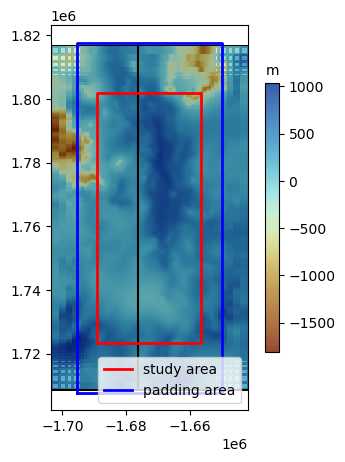

In [16]:
xv, yv = np.meshgrid(X_direction, Y_direction)
line_x = (xv[0, profile_y], xv[0, profile_y])
line_y = (yv[0, profile_y], yv[-1, profile_y])

# plot the resulting topography at the resolution of the mesh
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
plt.pcolormesh(
    x_ps_grid,
    y_ps_grid,
    Susceptibility[0, :, :],
    cmap="Greys",
    edgecolors="black",
)
im1 = plt.pcolormesh(x_ps_grid, y_ps_grid, topointer, cmap=cmap, alpha=0.8)
plt.plot(line_x, line_y, "-k")
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=0.7)
cb.ax.set_title("m", fontsize=10)
plt.plot(x_study_area, y_study_area, "red", linewidth=2, label="study area")
plt.plot(x_padding_area, y_padding_area, "blue", linewidth=2, label="padding area")
plt.legend(loc="lower right")

In [17]:
sus_cov = Susceptibility.copy()
# set the density values we want to assign to earth and air
cov_rock_cell = 1.0
cov_air_cell = 1e-10
below_CPD_cell = 1e-10

# go through each column of cells and assign air values to all cells above topography and earth values to those below
for i in range(0, X_PS.size):
    for j in range(0, Y_PS.size):
        sus_cov[np.nonzero(Depth < topointer[j, i]), j, i] = cov_air_cell
        sus_cov[np.nonzero(Depth >= topointer[j, i]), j, i] = cov_rock_cell
        sus_cov[np.nonzero(Depth >= CPDinter[j, i]), j, i] = below_CPD_cell
        # sus_cov[np.nonzero(Depth >= Mohointer[j, i]), j, i] = below_CPD_cell

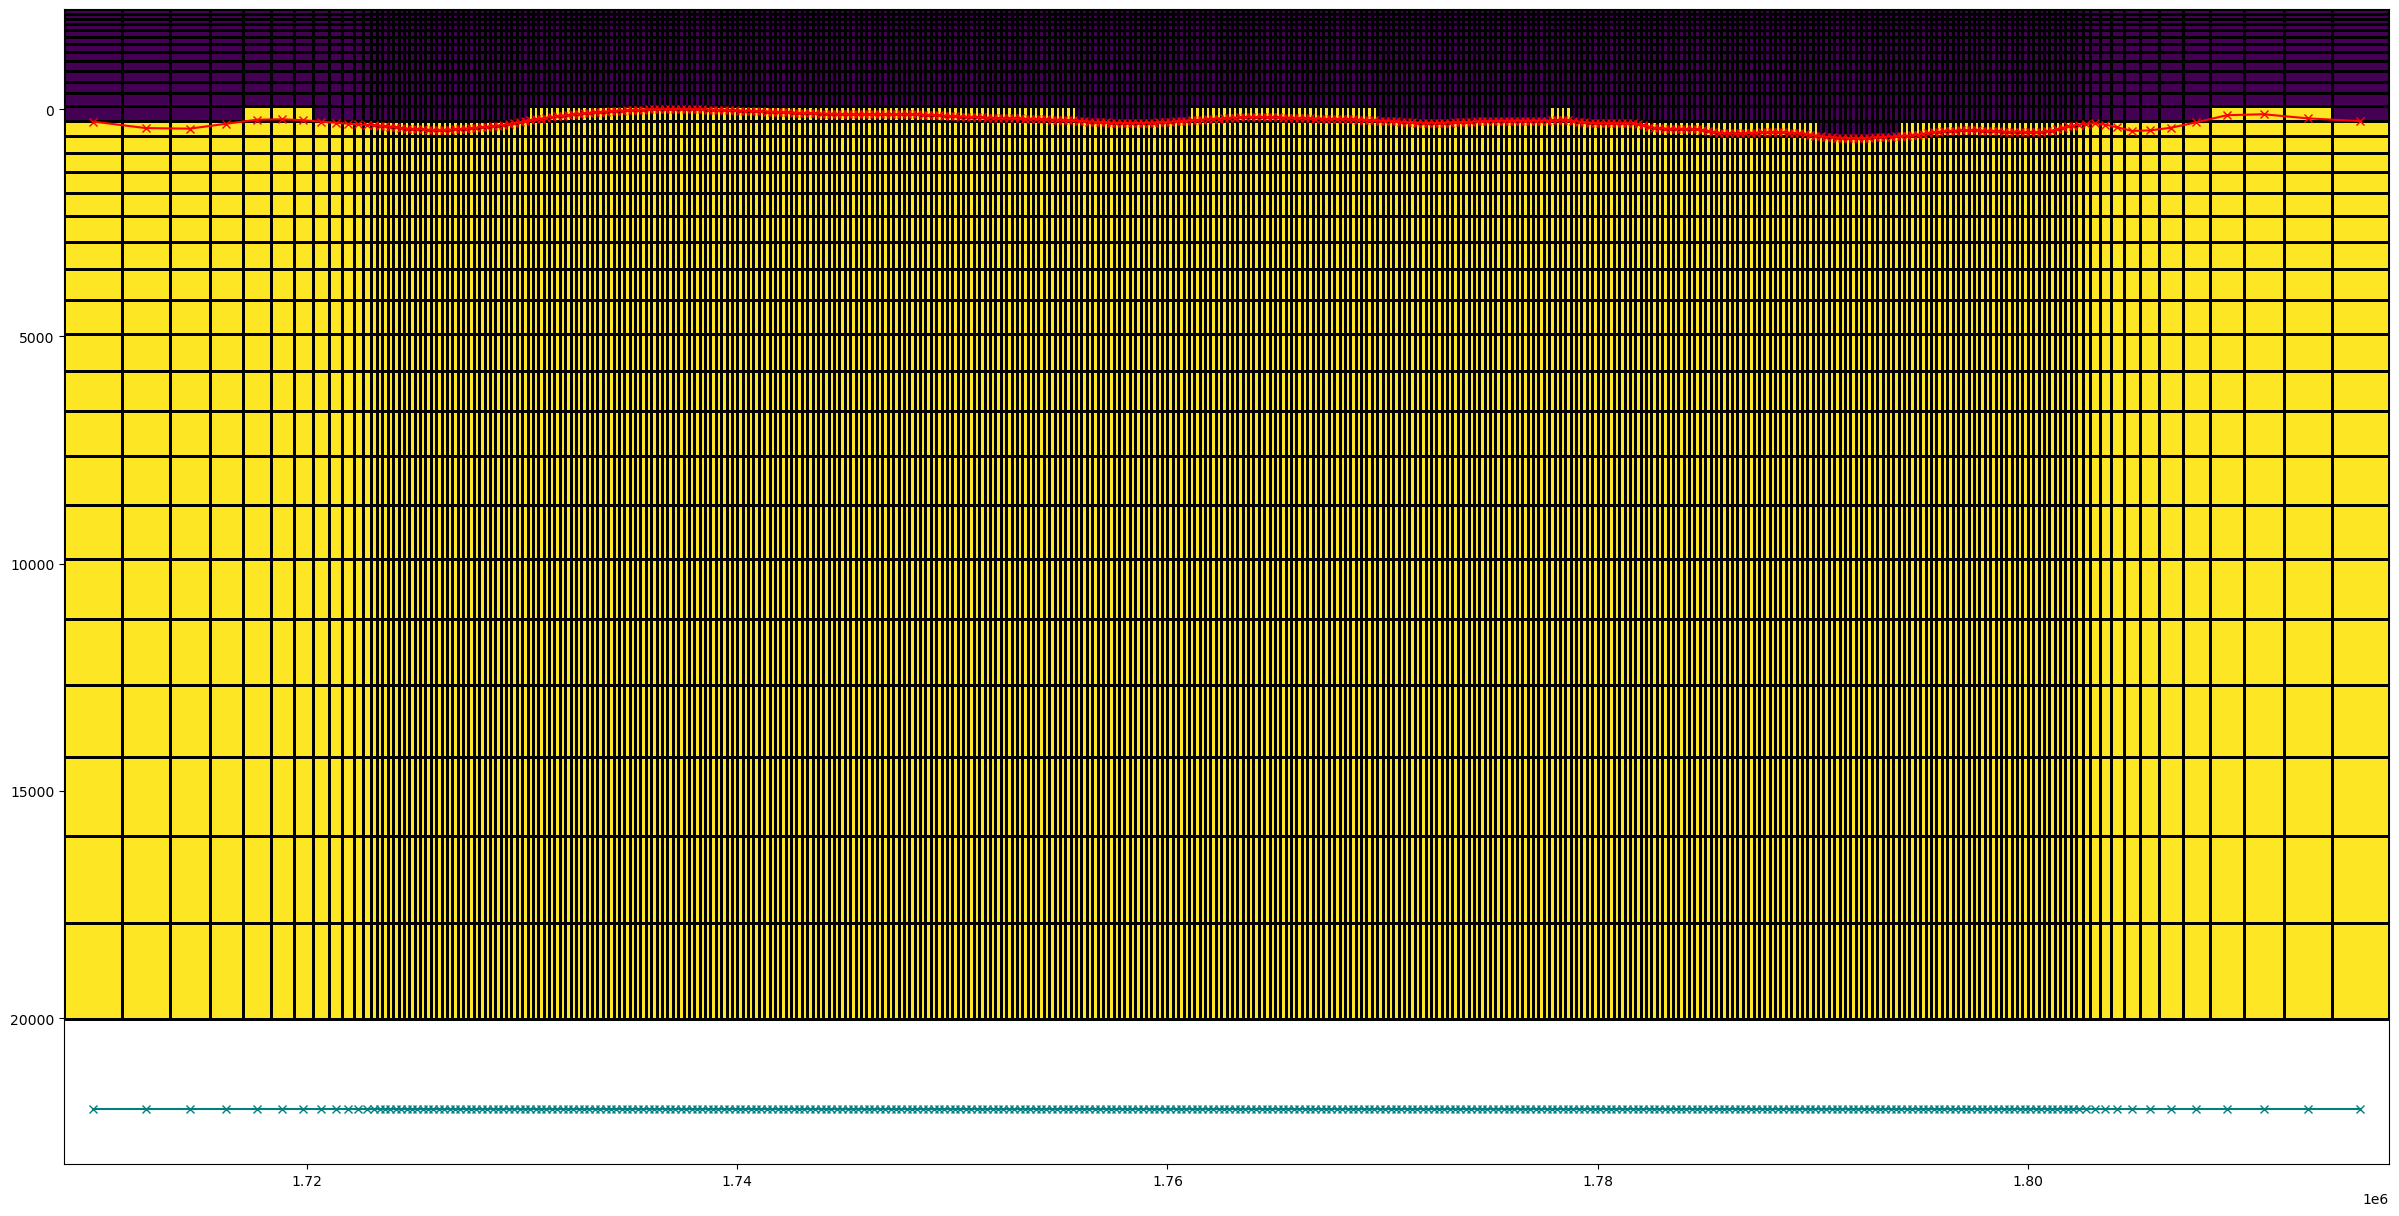

In [18]:
# plot an East-West profile through the resulting model
# also plot the interpolated topography to show how our model and the exact topography values differ
yi, zi = np.meshgrid(Y_direction, Z_direction)
fig = plt.figure(figsize=(30, 15))
plt.pcolormesh(yi, zi, sus_cov[:, :, profile_y], edgecolors="black")
plt.plot(mp_y_direction, topointer[:, profile_y], marker="x", c="red")
plt.plot(mp_y_direction, CPDinter[:, profile_y], marker="x", c="teal")

plt.gca().invert_yaxis()
# plt.ylim([1000,-4000])
plt.show()

In [19]:
profile_x = 210

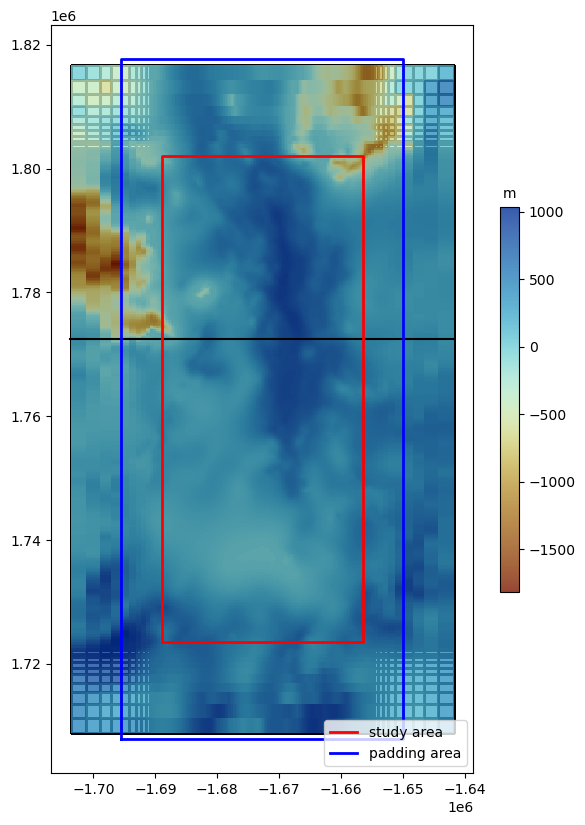

In [20]:
xv, yv = np.meshgrid(X_direction, Y_direction)
line_x = (xv[profile_x, 0], xv[profile_x, -1])
line_y = (yv[profile_x, 0], yv[profile_x, -1])

# plot the resulting topography at the resolution of the mesh
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
plt.pcolormesh(
    x_ps_grid,
    y_ps_grid,
    Susceptibility[0, :, :],
    cmap="Greys",
    edgecolors="black",
)
im1 = plt.pcolormesh(x_ps_grid, y_ps_grid, topointer, cmap=cmap, alpha=0.8)
plt.plot(line_x, line_y, "-k")
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=0.5)
cb.ax.set_title("m", fontsize=10)
plt.plot(x_study_area, y_study_area, "red", linewidth=2, label="study area")
plt.plot(x_padding_area, y_padding_area, "blue", linewidth=2, label="padding area")
plt.legend(loc="lower right")

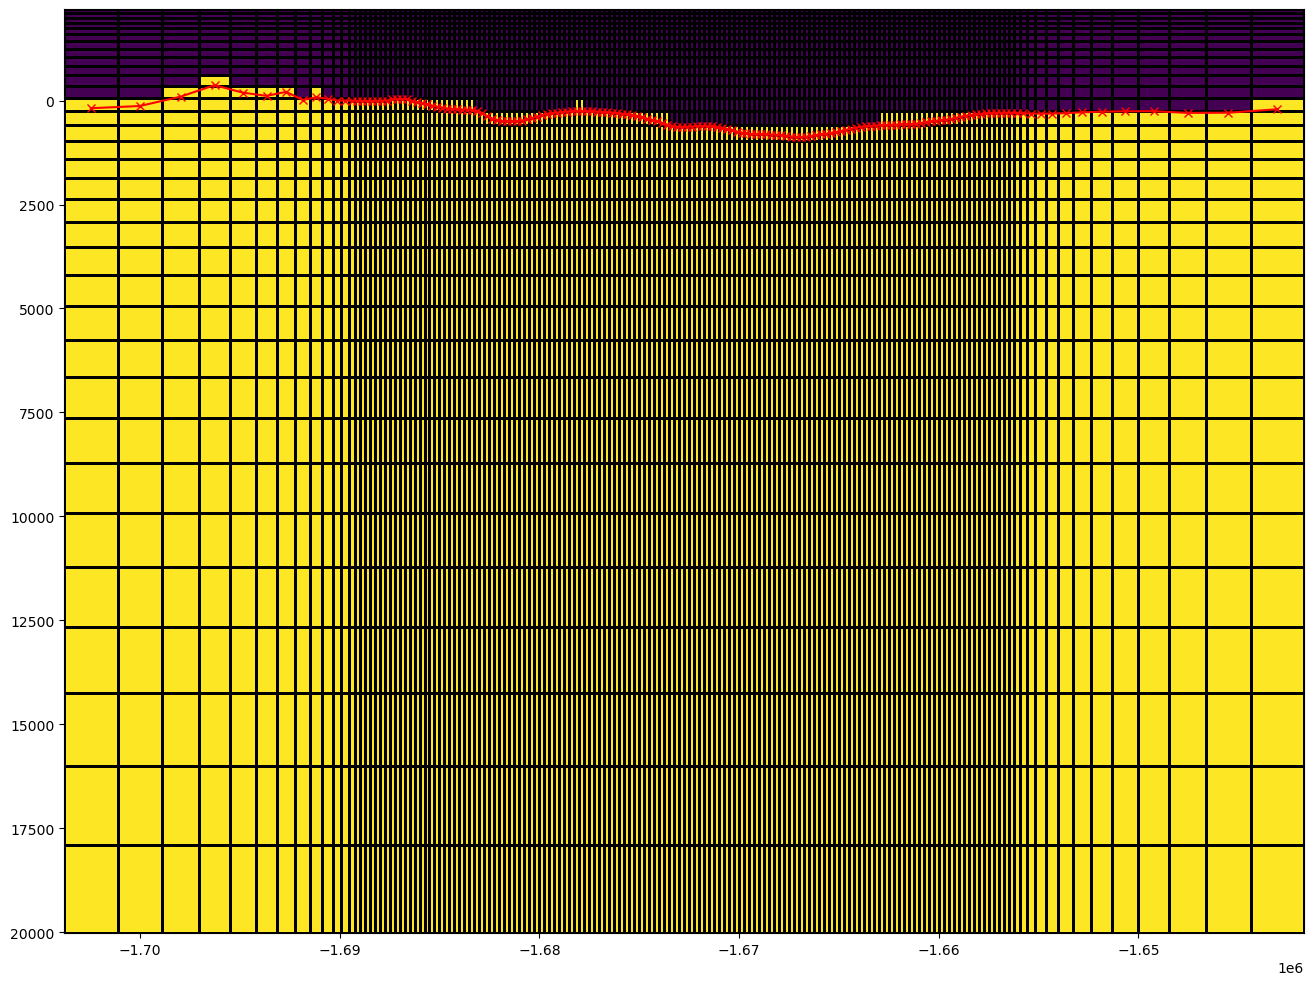

In [21]:
xi, zi = np.meshgrid(X_direction, Z_direction)
fig = plt.figure(figsize=(16, 12))
plt.pcolormesh(xi, zi, sus_cov[:, profile_x, :], edgecolors="black")
plt.plot(mp_x_direction, topointer[profile_x, :], marker="x", c="red")
# plt.plot(mp_x_direction, Mohointer[profile_x, :], marker="x", c="c")

plt.gca().invert_yaxis()
plt.show()
# fig.savefig('Mensa_range_sus_mesh_profile_x.png', format='png',dpi=500)

In [22]:
# create magnetic covariance file
model_sus_cov = Dataset(inversion_path + "Susceptibility_cov.nc", "w")
Grid_x_dim = model_sus_cov.createDimension("Northing", X_PS.size)
Grid_y_dim = model_sus_cov.createDimension("Easting", Y_PS.size)
Depthdim = model_sus_cov.createDimension("Depth", Depth.size)
bgdim = model_sus_cov.createDimension("bg_layers", bg_Susceptibility.size)

v_x_direction = model_sus_cov.createVariable("Northing", "f8", ("Northing"))
v_x_direction[:] = X_PS[:]
v_x_direction.units = "m"

v_x_direction_orig = model_sus_cov.createVariable("Northing_Origin", "f8")
v_x_direction_orig[:] = startx

v_y_direction = model_sus_cov.createVariable("Easting", "f8", ("Easting"))
v_y_direction[:] = Y_PS[:]
v_y_direction.units = "m"
v_y_direction_orig = model_sus_cov.createVariable("Easting_Origin", "f8")
v_y_direction_orig[:] = starty

vdepth = model_sus_cov.createVariable("Depth", "f8", ("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_sus_cov.createVariable("Depth_Origin", "f8")
vdepth_orig[:] = startz

vsus = model_sus_cov.createVariable(
    "Susceptibility", "f8", ("Depth", "Easting", "Northing")
)
vsus[:, :, :] = sus_cov[:, :, :]
vsus.units = " "

model_sus_cov.close()

In [23]:
# create gravity mesh
model_grav = Dataset(inversion_path + "start_grav.nc", "w")
Grid_x_dim = model_grav.createDimension("Northing", X_PS.size)
Grid_y_dim = model_grav.createDimension("Easting", Y_PS.size)
Depthdim = model_grav.createDimension("Depth", Depth.size)
bgdim = model_grav.createDimension("bg_layers", bg_densities.size)

v_x_direction = model_grav.createVariable("Northing", "f8", ("Northing"))
v_x_direction[:] = X_PS[:]
v_x_direction.units = "m"

v_x_direction_orig = model_grav.createVariable("Northing_Origin", "f8")
v_x_direction_orig[:] = startx

v_y_direction = model_grav.createVariable("Easting", "f8", ("Easting"))
v_y_direction[:] = Y_PS[:]
v_y_direction.units = "m"
v_y_direction_orig = model_grav.createVariable("Easting_Origin", "f8")
v_y_direction_orig[:] = starty

vdepth = model_grav.createVariable("Depth", "f8", ("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_grav.createVariable("Depth_Origin", "f8")
vdepth_orig[:] = startz

vdens = model_grav.createVariable("Density", "f8", ("Depth", "Easting", "Northing"))
vdens[:, :, :] = Density[:, :, :]
vdens.units = "kg/m3"

model_grav.close()

In [24]:
profile_y = 25

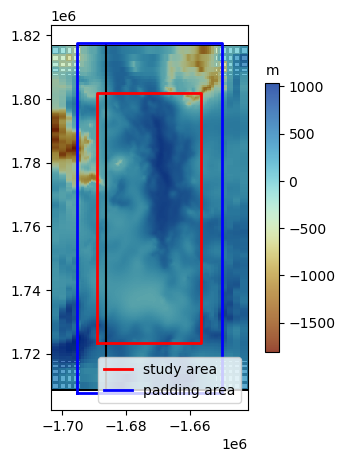

In [25]:
xv, yv = np.meshgrid(X_direction, Y_direction)
line_x = (xv[0, profile_y], xv[0, profile_y])
line_y = (yv[0, profile_y], yv[-1, profile_y])

# plot the resulting topography at the resolution of the mesh
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(1, 2, 1)
plt.pcolormesh(
    x_ps_grid,
    y_ps_grid,
    Density[0, :, :],
    cmap="Greys",
    edgecolors="black",
)
im1 = plt.pcolormesh(x_ps_grid, y_ps_grid, topointer, cmap=cmap, alpha=0.8)
plt.plot(line_x, line_y, "-k")
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=0.7)
cb.ax.set_title("m", fontsize=10)
plt.plot(x_study_area, y_study_area, "red", linewidth=2, label="study area")
plt.plot(x_padding_area, y_padding_area, "blue", linewidth=2, label="padding area")
plt.legend(loc="lower right")

In [26]:
dens_cov = Density.copy()
# set the density values we want to assign to earth and air
cov_rock_cell = 1.0
cov_air_cell = 1e-10
below_Moho_cell = 1e-10

# go through each column of cells and assign air values to all cells above topography and earth values to those below
for i in range(0, X_PS.size):
    for j in range(0, Y_PS.size):
        dens_cov[np.nonzero(Depth < topointer[j, i]), j, i] = cov_air_cell
        dens_cov[np.nonzero(Depth >= topointer[j, i]), j, i] = cov_rock_cell

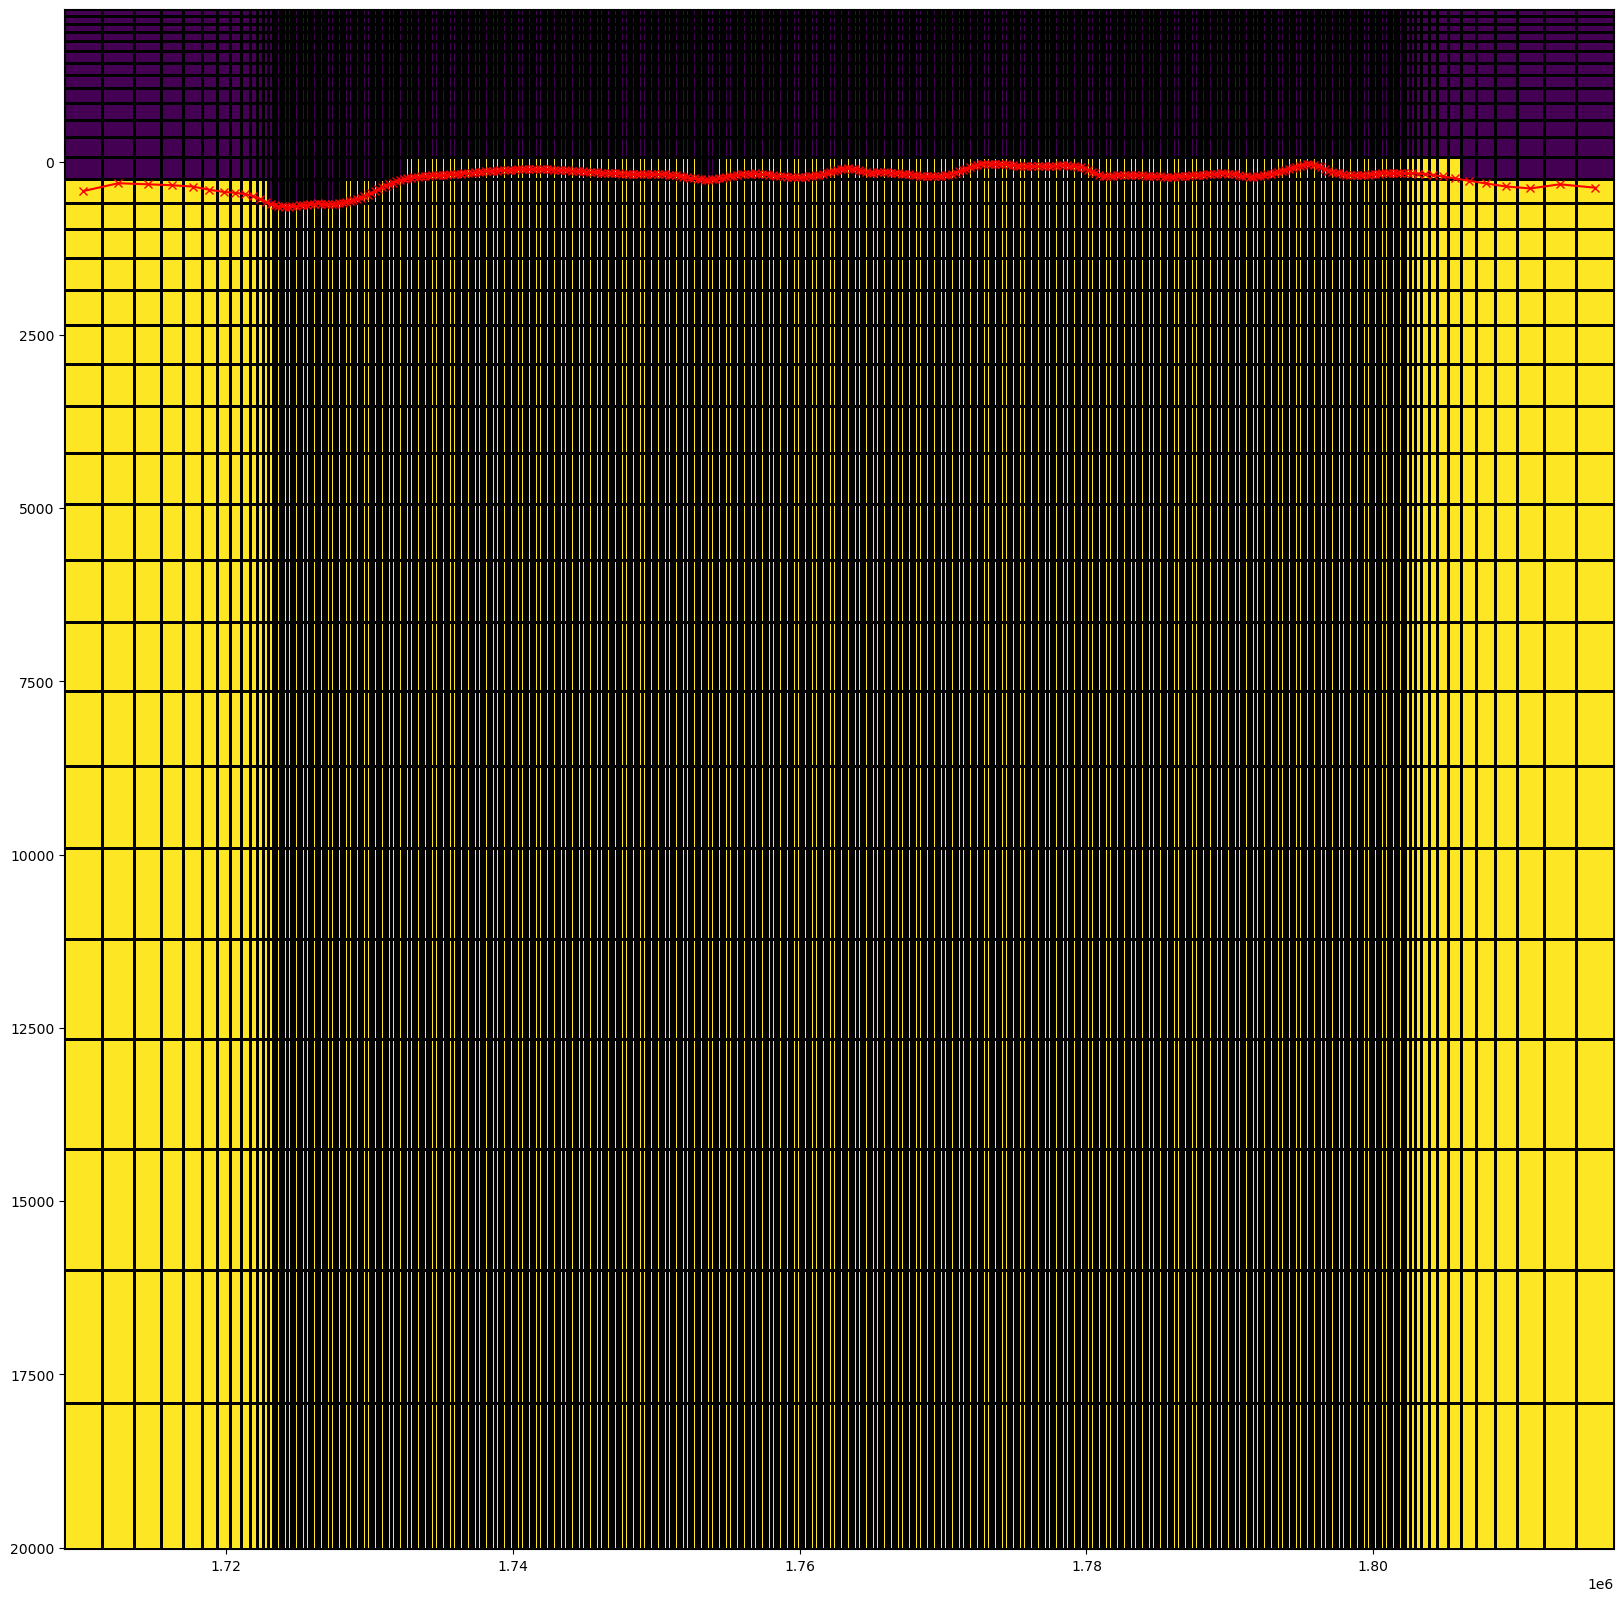

In [27]:
# plot an East-West profile through the resulting model
# also plot the interpolated topography to show how our model and the exact topography values differ
yi, zi = np.meshgrid(Y_direction, Z_direction)
fig = plt.figure(figsize=(20, 20))
plt.pcolormesh(yi, zi, dens_cov[:, :, profile_y], edgecolors="black")
plt.plot(mp_y_direction, topointer[:, profile_y], marker="x", c="red")
# plt.plot(mp_y_direction, Mohointer[:, profile_y], marker="x", c="c")

plt.gca().invert_yaxis()
plt.show()

In [28]:
profile_x = 210

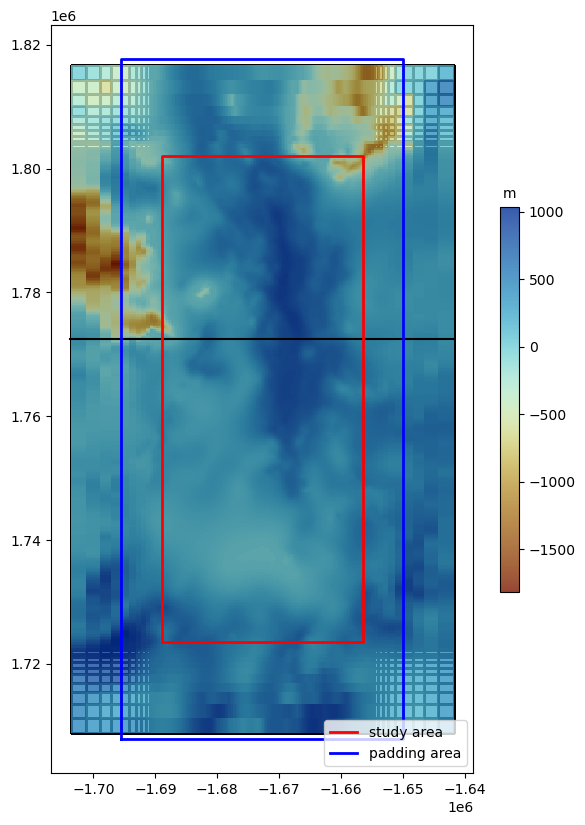

In [29]:
xv, yv = np.meshgrid(X_direction, Y_direction)
line_x = (xv[profile_x, 0], xv[profile_x, -1])
line_y = (yv[profile_x, 0], yv[profile_x, -1])

# plot the resulting topography at the resolution of the mesh
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
plt.pcolormesh(
    x_ps_grid,
    y_ps_grid,
    Density[0, :, :],
    cmap="Greys",
    edgecolors="black",
)
im1 = plt.pcolormesh(x_ps_grid, y_ps_grid, topointer, cmap=cmap, alpha=0.8)
plt.plot(line_x, line_y, "-k")
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, shrink=0.5)
cb.ax.set_title("m", fontsize=10)
plt.plot(x_study_area, y_study_area, "red", linewidth=2, label="study area")
plt.plot(x_padding_area, y_padding_area, "blue", linewidth=2, label="padding area")
plt.legend(loc="lower right")

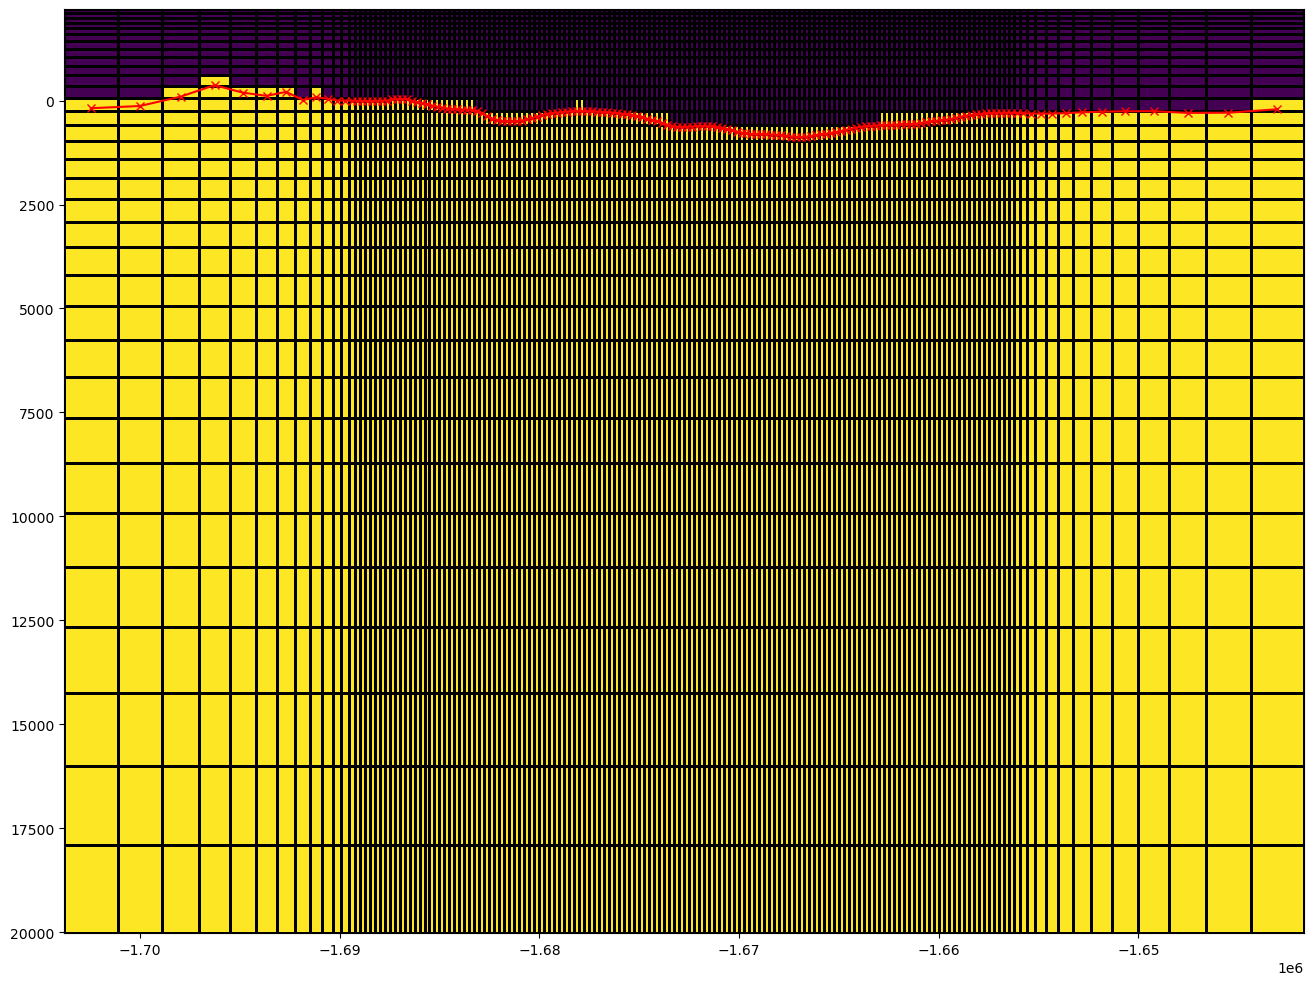

In [30]:
xi, zi = np.meshgrid(X_direction, Z_direction)
fig = plt.figure(figsize=(16, 12))
plt.pcolormesh(xi, zi, dens_cov[:, profile_x, :], edgecolors="black")
plt.plot(mp_x_direction, topointer[profile_x, :], marker="x", c="red")
# plt.plot(mp_x_direction, Mohointer[profile_x, :], marker="x", c="c")

plt.gca().invert_yaxis()
# plt.ylim([1000,-4000])
plt.show()
# fig.savefig('Mensa_range_sus_mesh_profile_x.png', format='png',dpi=500)

In [31]:
# create density covariance
model_dens_cov = Dataset(inversion_path + "Density_cov.nc", "w")
Grid_x_dim = model_dens_cov.createDimension("Northing", X_PS.size)
Grid_y_dim = model_dens_cov.createDimension("Easting", Y_PS.size)
Depthdim = model_dens_cov.createDimension("Depth", Depth.size)
bgdim = model_dens_cov.createDimension("bg_layers", bg_densities.size)

v_x_direction = model_dens_cov.createVariable("Northing", "f8", ("Northing"))
v_x_direction[:] = X_PS[:]
v_x_direction.units = "m"

v_x_direction_orig = model_dens_cov.createVariable("Northing_Origin", "f8")
v_x_direction_orig[:] = startx

v_y_direction = model_dens_cov.createVariable("Easting", "f8", ("Easting"))
v_y_direction[:] = Y_PS[:]
v_y_direction.units = "m"
v_y_direction_orig = model_dens_cov.createVariable("Easting_Origin", "f8")
v_y_direction_orig[:] = starty

vdepth = model_dens_cov.createVariable("Depth", "f8", ("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_dens_cov.createVariable("Depth_Origin", "f8")
vdepth_orig[:] = startz

vdens = model_dens_cov.createVariable("Density", "f8", ("Depth", "Easting", "Northing"))
vdens[:, :, :] = dens_cov[:, :, :]
vdens.units = "kg/m3"

model_dens_cov.close()

## Build MI covariacne mesh 
Assign every cell a value of 1 or close to zero (1e-20). A value of 1 means that this cell can freely vary in the inversion and that the cell is between topography and Moho/CDP. A value of 1e-20 means that the cell is kept fix in the inversion and that the cell is either above the topography or below the Moho/CDP.

In [32]:
# #coordinates
cell_boundaries = np.vstack((xq.flatten(), yq.flatten())).T

Topo_values_regridded = topointer

CDP_above_Moho_regridded = CPDinter

Moho_values_regridded = Mohointer


# Moho grid
Moho_values_regridded = np.vstack((xq.flatten(), yq.flatten(), Mohointer.flatten())).T

# Topo grid
Topo_values_regridded = np.vstack((xq.flatten(), yq.flatten(), topointer.flatten())).T

# CDP above Moho
CDP_above_Moho_regridded = np.vstack((xq.flatten(), yq.flatten(), CPDinter.flatten())).T

In [33]:
MI_covar_mesh = []

for j in range(nz):

    # define depth inverval
    lower_cell_boundary_index = Depth[
        j
    ]  # depth against each bottom cell boundary is tested against

    # create empty temporary variable
    ix_matrix_temp = np.zeros(len(cell_boundaries[:, 0]))

    for i in range(len(Topo_values_regridded[:, 0])):

        if (
            Topo_values_regridded[i, 2] > lower_cell_boundary_index
            or CDP_above_Moho_regridded[i, 2] < lower_cell_boundary_index
        ):
            ix_matrix_temp[i] = 0
        else:
            ix_matrix_temp[i] = 1

        ix_grd = ix_matrix_temp.reshape((len(Y_PS), len(X_PS)))

    MI_covar_mesh.append(ix_grd)

MI_cov_total_mesh = np.array(MI_covar_mesh)
MI_cov_total_mesh.shape

(33, 342, 158)

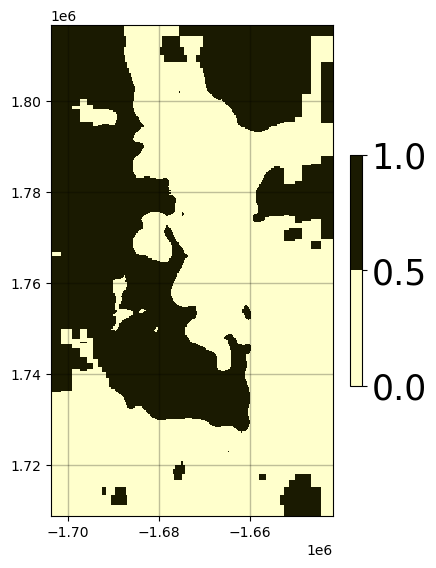

In [34]:
# define colorbar for air rock index
ar_ix_cmap = cm.lajolla.resampled(2)

# create figure
figure1 = plt.figure(figsize=(10, 10))

# subplot BA gravity data
ax1 = plt.subplot(1, 2, 1)

im1 = plt.pcolor(x_ps_grid, y_ps_grid, MI_cov_total_mesh[12, :, :], cmap=ar_ix_cmap)


axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im1, pad=0.05, shrink=0.3)
# cb.set_ticks([0,1])
# cb.set_ticklabels(["Air", "Rock"])
im1.figure.axes[1].tick_params(
    axis="y", labelsize=25
)  # increase label size of the colorbar
plt.grid(color="k", linestyle="-", linewidth=1, alpha=0.25)

In [35]:
model_sus_cov = Dataset(inversion_path + "Susceptibility_cov.nc", "w")
Grid_x_dim = model_sus_cov.createDimension("Northing", X_PS.size)
Grid_y_dim = model_sus_cov.createDimension("Easting", Y_PS.size)
Depthdim = model_sus_cov.createDimension("Depth", Depth.size)
bgdim = model_sus_cov.createDimension("bg_layers", bg_Susceptibility.size)

v_x_direction = model_sus_cov.createVariable("Northing", "f8", ("Northing"))
v_x_direction[:] = X_PS[:]
v_x_direction.units = "m"

v_x_direction_orig = model_sus_cov.createVariable("Northing_Origin", "f8")
v_x_direction_orig[:] = startx

v_y_direction = model_sus_cov.createVariable("Easting", "f8", ("Easting"))
v_y_direction[:] = Y_PS[:]
v_y_direction.units = "m"
v_y_direction_orig = model_sus_cov.createVariable("Easting_Origin", "f8")
v_y_direction_orig[:] = starty

vdepth = model_sus_cov.createVariable("Depth", "f8", ("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_sus_cov.createVariable("Depth_Origin", "f8")
vdepth_orig[:] = startz

vsus = model_sus_cov.createVariable(
    "Susceptibility", "f8", ("Depth", "Easting", "Northing")
)
vsus[:, :, :] = sus_cov[:, :, :]
vsus.units = " "

model_sus_cov.close()

In [36]:
model_MI_cov = Dataset(inversion_path + "MI_cov.nc", "w")
Grid_x_dim = model_MI_cov.createDimension("Northing", X_PS.size)
Grid_y_dim = model_MI_cov.createDimension("Easting", Y_PS.size)
Depthdim = model_MI_cov.createDimension("Depth", Depth.size)
bgdim = model_MI_cov.createDimension("bg_layers", bg_densities.size)

v_x_direction = model_MI_cov.createVariable("Northing", "f8", ("Northing"))
v_x_direction[:] = X_PS[:]
v_x_direction.units = "m"

v_x_direction_orig = model_MI_cov.createVariable("Northing_Origin", "f8")
v_x_direction_orig[:] = startx

v_y_direction = model_MI_cov.createVariable("Easting", "f8", ("Easting"))
v_y_direction[:] = Y_PS[:]
v_y_direction.units = "m"
v_y_direction_orig = model_MI_cov.createVariable("Easting_Origin", "f8")
v_y_direction_orig[:] = starty

vdepth = model_MI_cov.createVariable("Depth", "f8", ("Depth"))
vdepth[:] = Depth[:]
vdepth.units = "m"
vdepth_orig = model_MI_cov.createVariable("Depth_Origin", "f8")
vdepth_orig[:] = startz

vdens_cov = model_MI_cov.createVariable(
    "Density", "f8", ("Depth", "Easting", "Northing")
)
vdens_cov[:, :, :] = MI_cov_total_mesh[:, :, :]
vdens_cov.units = "kg/m3"

vdensthick = model_MI_cov.createVariable("bg_thicknesses", "f8", ("bg_layers"))
vdensthick[:] = bg_dens_thickness[:]
vdensthick.units = "m"

model_MI_cov.close()

In [37]:
import netCDF4 as nc4

## load mag data
mag_data_nc = nc4.Dataset(inversion_path + "magdata.nc")
XX_mag = mag_data_nc.variables["MeasPosX"][:]
YY_mag = mag_data_nc.variables["MeasPosY"][:]
mag_data = mag_data_nc.variables["T"][:]

## load mag mesh
mag_mesh_nc = nc4.Dataset(inversion_path + "start_mag.nc")
XX_sus_start_mesh = mag_mesh_nc.variables["Northing"][:]
YY_sus_start_mesh = mag_mesh_nc.variables["Easting"][:]
sus_start_mesh = mag_mesh_nc.variables["Susceptibility"][:]

# ## load sus cov mesh
sus_cov_mesh_nc = nc4.Dataset(inversion_path + "Susceptibility_cov.nc")
XX_sus_cov_mesh = sus_cov_mesh_nc.variables["Northing"][:]
YY_sus_cov_mesh = sus_cov_mesh_nc.variables["Easting"][:]
cov_sus = sus_cov_mesh_nc.variables["Susceptibility"][:]

mag_data_nc.close()
mag_mesh_nc.close()
sus_cov_mesh_nc.close()

In [38]:
xq_sus, yq_sus = np.meshgrid(XX_sus_start_mesh, YY_sus_start_mesh, indexing="xy")
xq_sus_cov, yq_sus_cov = np.meshgrid(XX_sus_cov_mesh, YY_sus_cov_mesh, indexing="xy")

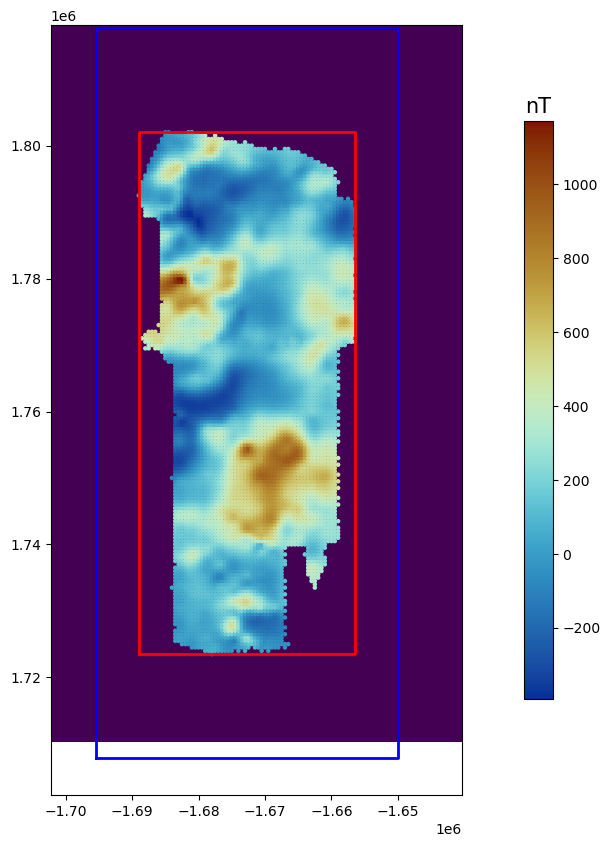

In [39]:
figure1 = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(1, 1, 1)
plt.pcolormesh(xq_sus_cov, yq_sus_cov, cov_sus[32, :, :])  # plotting
im = plt.scatter(XX_mag, YY_mag, 5, c=mag_data, cmap=cmap_rev)
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im, shrink=0.75)
cb.ax.set_title("nT", fontsize=15)
plt.plot(x_study_area, y_study_area, "red", linewidth=2, label="study area")
plt.plot(x_padding_area, y_padding_area, "blue", linewidth=2, label="padding area")

#### Sanity check

In [40]:
## load mag data
grav_data_nc = nc4.Dataset(inversion_path + "gravdata.nc")
XX_grav = grav_data_nc.variables["MeasPosX"][:]
YY_grav = grav_data_nc.variables["MeasPosY"][:]
grav_data = grav_data_nc.variables["Scalar_gravity"][:]

## load density mesh
grav_mesh_nc = nc4.Dataset(inversion_path + "start_grav.nc")
XX_dens_start_mesh = grav_mesh_nc.variables["Northing"][:]
YY_dens_start_mesh = grav_mesh_nc.variables["Easting"][:]
dens_start_mesh = grav_mesh_nc.variables["Density"][:]

# ## load sus cov mesh
dens_cov_mesh_nc = nc4.Dataset(inversion_path + "Density_cov.nc")
XX_dens_cov_mesh = dens_cov_mesh_nc.variables["Northing"][:]
YY_dens_cov_mesh = dens_cov_mesh_nc.variables["Easting"][:]
cov_dens = dens_cov_mesh_nc.variables["Density"][:]

grav_data_nc.close()
grav_mesh_nc.close()
dens_cov_mesh_nc.close()

In [41]:
xq_dens, yq_dens = np.meshgrid(XX_dens_start_mesh, YY_dens_start_mesh, indexing="xy")
xq_dens_cov, yq_dens_cov = np.meshgrid(
    XX_dens_cov_mesh, YY_dens_cov_mesh, indexing="xy"
)

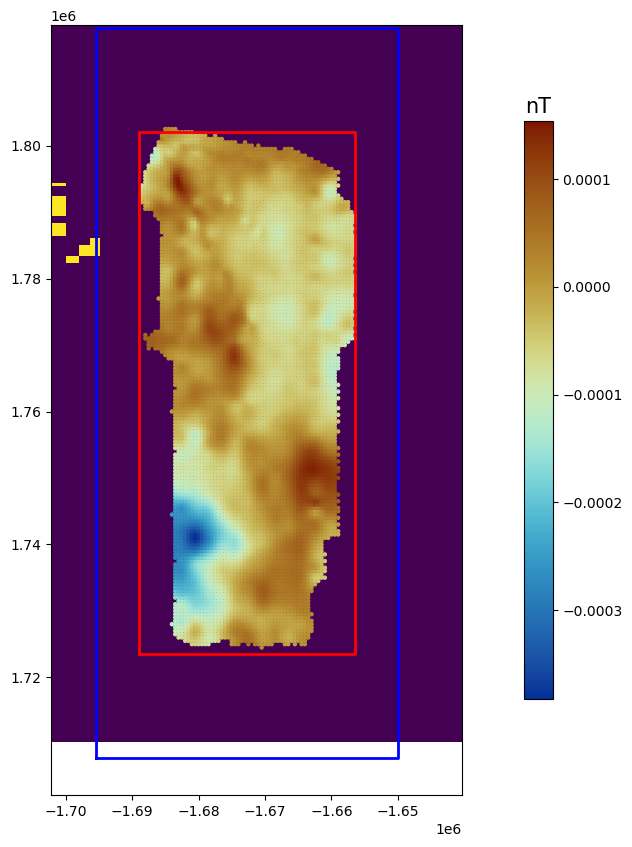

In [42]:
figure1 = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(1, 1, 1)
plt.pcolormesh(xq_dens_cov, yq_dens_cov, cov_dens[5, :, :])  # plotting
im = plt.scatter(XX_grav, YY_grav, 5, c=grav_data, cmap=cmap_rev)
axes = plt.gca()
axes.set_aspect(1)
cb = plt.colorbar(im, shrink=0.75)
cb.ax.set_title("nT", fontsize=15)
plt.plot(x_study_area, y_study_area, "red", linewidth=2, label="study area")
plt.plot(x_padding_area, y_padding_area, "blue", linewidth=2, label="padding area")

In [43]:
# degree to rad
degree_value = -90
rad_value = degree_value * (np.pi / 180)
print(rad_value)

-1.5707963267948966


#### Create run file

In [44]:
# location of the jif3D executables on your system
execpath = "../../../../PhD_project/Wilkes_Subglacial_Basin_WSB/jif3D/bin/"
# program we want to run
progname = "jointinv"
options = " --inclination -1.571 --declination 0 --fieldstrength 40483.4 --mutual_information 100 --magminerr 10 --minsus -0.1 --maxsus 0.1 --scalminerr 2e-5 --mindens -250 --maxdens 250 --dens_covmod density_cov.nc --sus_covmod Susceptibility_cov.nc --coupling_validity MI_cov.nc"

# name of the density starting mesh
gravmesh = "start_grav.nc"
# name of the gravity data file
gravdata = "gravdata.nc"
# name of the susecptibility starting mesh
magmesh = "start_mag.nc"
# name of the magnetics data file
magdata = "magdata.nc"

## set data weights. 0 means no data

# gravity data
gravweight = 1
# FTG data
ftgweight = 0.0
# magnetic data
magweight = 1.0
magvectorweight = 0.0
mtweight = 0.0
DCResistivity = 0.0
tomographyweight = 0.0
surfacewaveweight = 0.0
# coupling term
coupling = 20000
# density regularization
gravregularization = 1
# susceptibility regularization
magregularization = 1
# maximum number of iterations
iterations = 30

# write all information to file
f = open(inversion_path + "run", "w")
f.write(execpath + progname + options + " <<eof \n")
f.write(magmesh + "\n")
f.write(str(gravweight) + "\n")
f.write(str(ftgweight) + "\n")
f.write(gravdata + "\n")
f.write(gravmesh + "\n")
f.write(str(magweight) + "\n")
f.write(magdata + "\n")
f.write(magmesh + "\n")
f.write(str(magvectorweight) + "\n")
f.write(str(mtweight) + "\n")
f.write(str(DCResistivity) + "\n")
f.write(str(tomographyweight) + "\n")
f.write(str(surfacewaveweight) + "\n")
f.write(str(coupling) + "\n")
f.write(str(gravregularization) + "\n")
f.write(str(magregularization) + "\n")
f.write(str(iterations) + "\n")
f.write("eof\n")
f.close()